In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

RESULTS_DIR = PROJECT_ROOT / "results"
PLOTS_DIR   = PROJECT_ROOT / "plots"
DATA_DIR = PROJECT_ROOT/"data"

for d in [RESULTS_DIR, PLOTS_DIR]:
    d.mkdir(exist_ok=True)

In [2]:
trades = pd.read_csv(
    RESULTS_DIR / "baseline_trades.csv",
    parse_dates=["entry_time", "exit_time"]
)

df = pd.read_csv(
    DATA_DIR / "nifty_with_regimes.csv",
    parse_dates=["timestamp"]
).sort_values("timestamp").reset_index(drop=True)

print(trades.shape, df.shape)


(613, 7) (19212, 2668)


In [4]:
# enrich trades with market context

ctx = pd.merge_asof(
    trades.sort_values("entry_time"),
    df.sort_values("timestamp"),
    left_on="entry_time",
    right_on="timestamp",
    direction="backward"
)


In [5]:
# compute ats (if not present)

if "atr_14" not in df.columns:
    high = df["spot_high"]
    low  = df["spot_low"]
    close = df["spot_close"]

    tr = pd.Series(
        np.maximum.reduce([
        high - low,
        (high - close.shift()).abs(),
        (low - close.shift()).abs()
    ]),
    index=df.index
    )

    df["atr_14"] = tr.rolling(14).mean()

    ctx = pd.merge_asof(
        ctx.sort_values("entry_time"),
        df[["timestamp", "atr_14"]].sort_values("timestamp"),
        left_on="entry_time",
        right_on="timestamp",
        direction="backward"
    )


In [6]:
ctx["signal_strength"] = abs(ctx["ema_5"] - ctx["ema_15"])

In [7]:
# z-score outlier detection

pnl = ctx["pnl"]
ctx["pnl_z"] = (pnl - pnl.mean()) / pnl.std()

outliers = ctx[(ctx["pnl"] > 0) & (ctx["pnl_z"] > 3)].copy()
normal_profitable = ctx[(ctx["pnl"] > 0) & (ctx["pnl_z"] <= 3)].copy()

print("Total profitable trades:", (ctx["pnl"]>0).sum())
print("Outliers:", len(outliers))

Total profitable trades: 185
Outliers: 15


In [8]:
summary = {
    "Total Trades": len(ctx),
    "Profitable Trades": (ctx["pnl"] > 0).sum(),
    "Outlier Trades": len(outliers),
    "Outlier %": 100 * len(outliers) / max(1, (ctx["pnl"] > 0).sum()),
    "Avg PnL (Outliers)": outliers["pnl"].mean(),
    "Avg PnL (Normal Profitable)": normal_profitable["pnl"].mean()
}

pd.Series(summary)


Total Trades                   613.000000
Profitable Trades              185.000000
Outlier Trades                  15.000000
Outlier %                        8.108108
Avg PnL (Outliers)             700.741038
Avg PnL (Normal Profitable)    151.051482
dtype: float64

In [9]:
compare_features = [
    "regime",
    "avg_iv",
    "iv_spread",
    "atr_14",
    "ce_delta",
    "ce_gamma",
    "duration"
]

comparison = pd.DataFrame({
    "Outliers": outliers[compare_features].mean(),
    "Normal Profitable": normal_profitable[compare_features].mean()
})

comparison


,Outliers,Normal Profitable
regime,1.000000,1.000000
avg_iv,0.001778,0.001710
iv_spread,-0.000200,-0.000200
atr_14,74.947684,69.604865
ce_delta,0.965054,0.979860
ce_gamma,0.008413,0.006271
duration,1901.000000,846.852941


#### Scatter PnL vs Duration

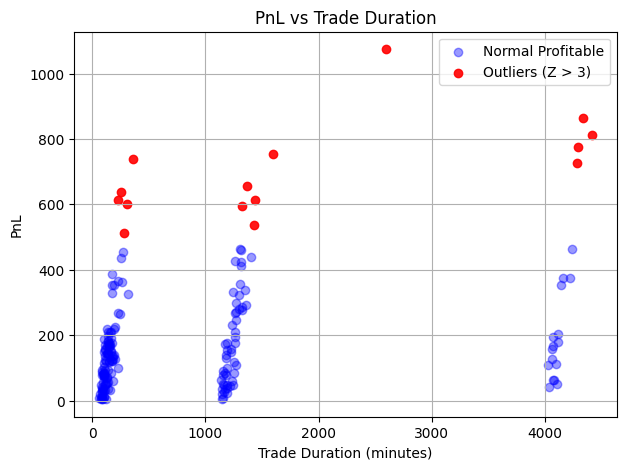

Saved: outlier_pnl_vs_duration.png


In [13]:
plt.figure(figsize=(7,5))

# Normal profitable trades
plt.scatter(
    normal_profitable["duration"],
    normal_profitable["pnl"],
    alpha=0.4,
    label="Normal Profitable",
    color="blue"
)

# Outlier trades
plt.scatter(
    outliers["duration"],
    outliers["pnl"],
    alpha=0.9,
    label="Outliers (Z > 3)",
    color="red"
)

plt.xlabel("Trade Duration (minutes)")
plt.ylabel("PnL")
plt.title("PnL vs Trade Duration")
plt.legend()
plt.grid(True)

plt.savefig(PLOTS_DIR / "outlier_pnl_vs_duration.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close()

print("Saved: outlier_pnl_vs_duration.png")



#### box plot (feature distribution)

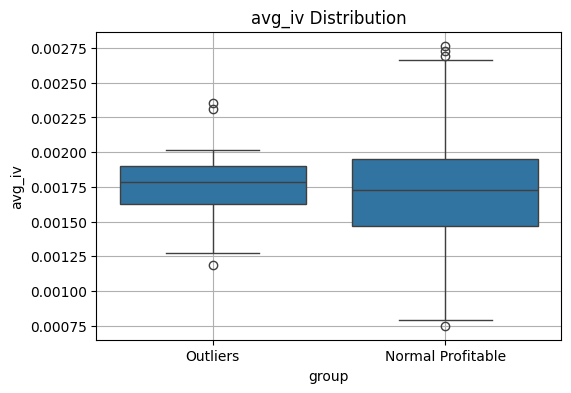

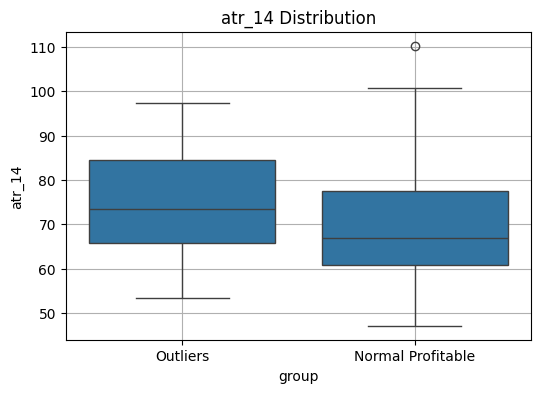

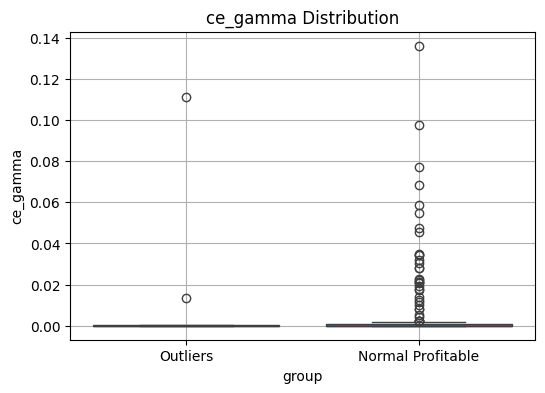

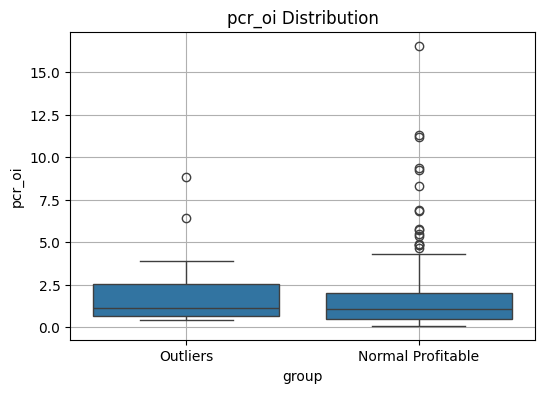

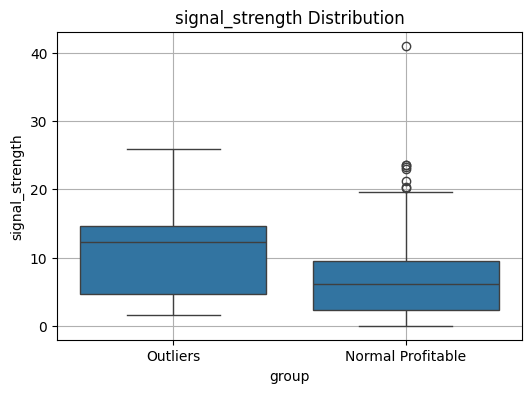

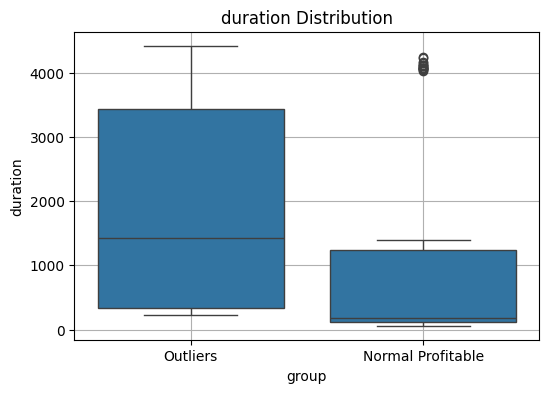

Saved box plots for feature distributions


In [14]:
features_to_plot = [
    "avg_iv",
    "atr_14",
    "ce_gamma",
    "pcr_oi",
    "signal_strength",
    "duration"
]

plot_df = pd.concat([
    outliers.assign(group="Outliers"),
    normal_profitable.assign(group="Normal Profitable")
])

for feature in features_to_plot:
    plt.figure(figsize=(6,4))
    sns.boxplot(
        data=plot_df,
        x="group",
        y=feature
    )
    plt.title(f"{feature} Distribution")
    plt.grid(True)

    plt.savefig(
        PLOTS_DIR / f"boxplot_{feature}.png",
        dpi=150,
        bbox_inches="tight"
    )
    plt.show()
    plt.close()

print("Saved box plots for feature distributions")


#### Correlation heatmap (outliers only)

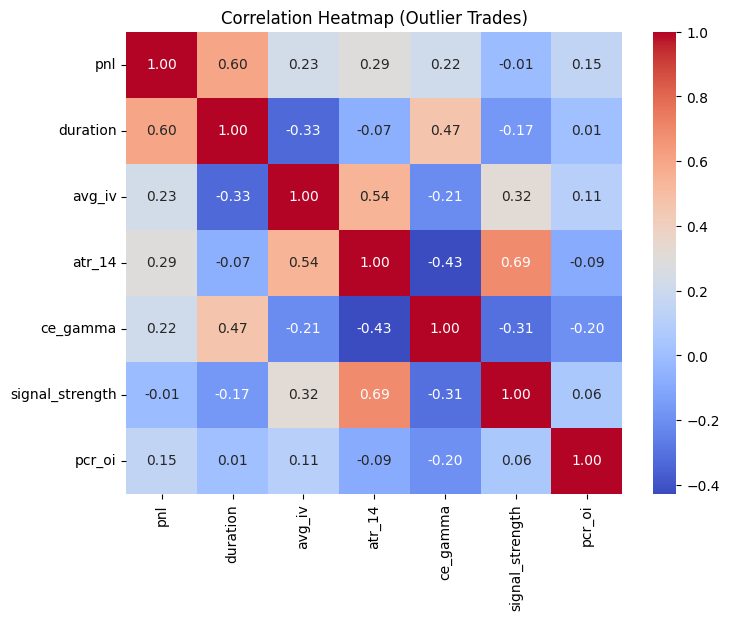

Saved correlation heatmap


In [15]:
corr_features = [
    "pnl",
    "duration",
    "avg_iv",
    "atr_14",
    "ce_gamma",
    "signal_strength",
    "pcr_oi"
]

corr = outliers[corr_features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Heatmap (Outlier Trades)")

plt.savefig(
    PLOTS_DIR / "outlier_correlation_heatmap.png",
    dpi=150,
    bbox_inches="tight"
)
plt.show()
plt.close()

print("Saved correlation heatmap")


#### Time of Day Distribution

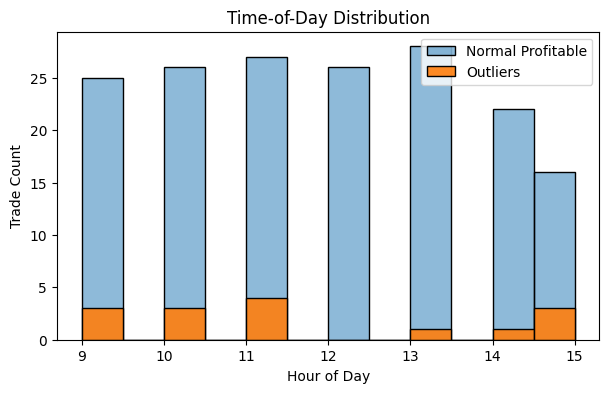

Saved time-of-day distribution plot


In [16]:
outliers["hour"] = outliers["entry_time"].dt.hour
normal_profitable["hour"] = normal_profitable["entry_time"].dt.hour

plt.figure(figsize=(7,4))
sns.histplot(
    normal_profitable["hour"],
    bins=12,
    alpha=0.5,
    label="Normal Profitable"
)
sns.histplot(
    outliers["hour"],
    bins=12,
    alpha=0.9,
    label="Outliers"
)

plt.xlabel("Hour of Day")
plt.ylabel("Trade Count")
plt.title("Time-of-Day Distribution")
plt.legend()

plt.savefig(
    PLOTS_DIR / "outlier_time_of_day.png",
    dpi=150,
    bbox_inches="tight"
)
plt.show()
plt.close()

print("Saved time-of-day distribution plot")


#### Insights Summary

In [17]:
insights = {
    "Outlier % of Profitable Trades":
        round(100 * len(outliers) / max(1, (ctx["pnl"] > 0).sum()), 2),

    "Avg PnL (Outliers)":
        round(outliers["pnl"].mean(), 2),

    "Avg PnL (Normal Profitable)":
        round(normal_profitable["pnl"].mean(), 2),

    "Dominant Regime (Outliers)":
        outliers["regime"].value_counts().idxmax(),

    "Peak Trading Hour (Outliers)":
        outliers["hour"].value_counts().idxmax(),

    "Avg IV (Outliers)":
        round(outliers["avg_iv"].mean(), 3)
}

pd.Series(insights)


Outlier % of Profitable Trades      8.110
Avg PnL (Outliers)                700.740
Avg PnL (Normal Profitable)       151.050
Dominant Regime (Outliers)          1.000
Peak Trading Hour (Outliers)       11.000
Avg IV (Outliers)                   0.002
dtype: float64